# Approximate Quantile Computation on Large-Scale Data

February 2023

## Task description

* Realize Greenwald & Khanna's quantile algorithm from the research paper titled ["A Survey of Approximate Quantile Computation on Large-Scale Data"](https://arxiv.org/pdf/2004.08255.pdf)

* Use BasicQuantileAlgorithm as a base class for realization

* Test the alghoritm at page "Test"

## Abstract implementation

A basic class for the implementation

In [25]:
from typing import List

class BasicQuantileAlgorithm:
    """
    Abstract class for quantile computing algorithm
    """
    
    def __init__(self) -> None:
        """
        Initializer for algorithm
        """
    
    def compute_quantile(self, q) -> float:
        """
        Implementation of some quantile algorithm
        """
        raise NotImplementedError('compute_quantile is not implemented')
    
    def compute(self, q) -> float:
        assert 0.0 <= q <= 1.0, f"q should be in [0;1]. Got {q}"
        """
        Compute the q-th quantile
        
        Hides implementation of _compute_quantile. 
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return self.compute_quantile(q)
    
    # NOTE: multi_compute is just a basic function
    # for computing multiple quantile with one function call. 
    # This can be modified, so that multiple quantiles
    # calculation become efficient. 
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return [self.compute(q) for q in qs]

In [26]:
import numpy as np

class NumpyQuantileAlgorithm(BasicQuantileAlgorithm):
    """
    Example of quantile algorithm
    
    This algorithm implementation is 
    based on the numpy.quantile. 
    """
    def __init__(self):
        """
        Initializer of the class. 
        
        It initializes self.data with empty list
        """
        self.data = []
    
    def add_item(self, item):
        """
        Adds an item to the existing data
        """
        self.data.append(item)
    
    def add_multiple_items(self, items):
        """
        Adds multiple items to the existing data
        """
        self.data += items
    
    def compute_quantile(self, q) -> float:
        """
        Compute the q-th quantile
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return np.quantile(self.data, q)
    
    # NOTE: Here, for multi_compute we
    # can just call the same function
    # compute_quantile, because it could
    # take a vector of multiple quantiles.
    # This is more efficient, than basic 
    # function call, because of the 
    # vectorized implementation.
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return list(self.compute_quantile(qs))

In [27]:
class GK01QuantileAlgorithm(BasicQuantileAlgorithm):
    """
   Realization of Greenwald & Khanna's quantile algorithm

   """

    def __init__(self, eps=0.01):
        """
      Initializer of the class.

      It initializes self.epsilon with the given parameter eps or by default 0.01,
      self.n with 0 (number of the received elements) and
      self.summary with empty list. 
      
      Summary is a data structure special for GK01, in my implementation 
      it is represented as an array of arrays. 
      Each subarray i consist of 3 elements: v_i, g_i, d_i, 
      where v_i is a data point, 
      g_i = rank_min(v_i) - rank_min(v_{i-1}), 
      d = rank_max(v_i) - rank_min(v_i). 
      Note that v_i <= v_{i+1} for all elements in the summary.

      :param eps: epsilon approximation
      """
        self.n = 0
        self.summary = []
        self.epsilon = eps


    def find_position(self, item):
        """
        Binary search algorithm
        Find position i to insert the item, where v_(i-1)<=item<v_(i)
        :param item: element for finding the position
        """
        # If no elements in the summary, item will be the first
        if len(self.summary) == 0:
            return 0
        # If item is new max or min in summary
        if item < self.summary[0][0]:
            return 0
        if item >= self.summary[-1][0]:
            return len(self.summary)

        # Binary search
        start = 0
        stop = len(self.summary) - 1
        cur_pos = int((start + stop) / 2)
        while not (self.summary[cur_pos - 1][0] <= item < self.summary[cur_pos][0]):
            if start == cur_pos:
                cur_pos = stop
            elif cur_pos == stop:
                cur_pos = start
            elif self.summary[cur_pos][0] <= item:
                start = cur_pos
                cur_pos = int((start + stop) / 2)
            else:
                stop = cur_pos
                cur_pos = int((start + stop) / 2)
        return cur_pos

    def delete(self):
        """
        Check which of the elements in the summary can be merged into one.
        Look for all possible sequences in the summary, where 
        d_{i}+g_{j}+...+g_{i} <= 2*epsilon*N for j<i, j is minimal, i is maximal possible index. 
        Each sequence will be replaced with the new entry [v_{i}, g_{j}+...+g_{i}, d_{i}]. 
        """
        for i in range(len(self.summary) - 2, 0, -1):
            j = i - 1
            if not ((0 <= j <= len(self.summary) - 1) and (0 <= i <= len(self.summary) - 1)):
                continue
            # sum is equal to d_{i}+g_{j}+...+g_{i}
            sum = self.summary[i][1] + self.summary[i][2] + self.summary[j][1]

            # Find minimal j such that condition sum< 2*epsilon*N holds
            while (j >= 0) and (sum < 2 * self.n * self.epsilon):
                j -= 1
                sum += self.summary[j][1]
            j += 1
            if j < i:
                # Replace the obtained sequence from the summary 
                # with new element [v_{i}, g_{j}+...+g_{i}, d_{i}]
                self.summary[i][1] = sum - self.summary[i][2] - self.summary[j - 1][1]
                del self.summary[j:i]

    def add_item(self, item):
        """
        Add an item to the summary
        :param item: one element from a stream
        """
        # Perform a deletion when each floor(1 / (2 * self.epsilon)) element arrives
        if self.n % int(1 / (2 * self.epsilon)) == 0:
            self.delete()
        
        # Find position i to insert the item, where v_(i-1)<=item<v_(i)
        ind = self.find_position(item)

        # Insert an item in the Summary
        if ind == len(self.summary):
          # item is bigger than the last element in the summary
            self.summary.append([item, 1, 0]) 
        elif ind == 0:
          # item is less than the firt element in the summary
            self.summary.insert(0, [item, 1, 0])
        else:
            self.summary.insert(ind, [item, 1, self.summary[ind][1] + self.summary[ind][2] - 1])

        # Update the number of elements
        self.n += 1


    def add_multiple_items(self, items):
        """
      Add multiple items to the summary one by one
      :param items: a list of items arrived from a stream
      """
        for i in items:
            self.add_item(i)

    def compute_quantile(self, q) -> float:
        """
        Compute the q-th quantile

        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        # If sammari does not contain any elements yet
        if len(self.summary) ==0:
            return 0
        
        # Calculate a range within which the interesting quantile lies
        err = int(self.epsilon * self.n)
        r = int(q * self.n)
        if r >= self.n - err:
            return self.summary[-1][0]
        sum = 0
        # Find v_i  with minimum  i  for which  rank_max(v_{i+1})>(q+ϵ)N .
        for i in range(len(self.summary)):
            sum += self.summary[i][1]
            if sum + self.summary[i][2] > r + err:
                return self.summary[i - 1][0]
        return self.summary[0][0]

    def multi_compute(self, qs) -> List[float]:
        """
      Compute multiple q-th quantiles

      :param qs: list of quantiles to compute,
          all should be between 0 and 1 inclusive
      :return: list of computed quantiles
      """
        return [self.compute_quantile(i) for i in qs]



> REPORT ABOUT THE ALGORITHM

### Explanation of GK01 algorithm

#### Basic terms

The naive algorithm for finding q-th quantile is to get an element at $⌊qN⌋$-th position (i.e. rank) in a sorted sequence of N elements.
However, this algorithm has a huge space consuption for big amount of stream data (elements arrive one by one). 
To decrease the number of elements stored in the memory, one may allow $\epsilon$ approximation of q-th quantile, when any element with rank in the range $[rank_{min}; rank_{max}]$, where $rank_{min} = ⌊(q-\epsilon)N⌋$ and $rank_{max} = ⌊(q+\epsilon)N⌋$, could be the answer.

A Greenwald & Khannan's algorithm (GK01) is based on the data structure named Summary. In my implementation it is represented as an array of arrays. Each subarray consist of 3 elements: $v, g, d$, where $v$ is a data point, $g$ is a difference between $rank_{min}$ of current element and $rank_{min}$ of element before it, $d$ is a difference between $rank_{max}$ and $rank_{min}$ of current data point. Note that $d=0$ for the first and last elements and $v_{i} ≤ v_{i+1}$ for all elements in the summary.

* $g_{0}=rank_{min}(v_{0})=1$

* $g_{i}=rank_{min}(v_{i})-rank_{min}(v_{i-1})$

* $d_{i}=rank_{max}(v_{i})-rank_{min}(v_{i})$

* $rank_{min}(v_{i})= \sum \limits _{j=0} ^{i} g_{j}$

* $rank_{max}(v_{i})= d_{i} + \sum \limits _{j=0} ^{i} g_{j}$


<!-- !!! * $err=\frac{\max \limits _{j \in N} (g_{j}+d_{j})}{2}$

* $rank(v_{i}) - err <= rank_{min}(v_{i}) <= rank(v_{i}) <= rank_{max}(v_{i}) <= rank(v_{i}) + err$ -->


### Algoritm explanation

Insertion of the element based on 4 steps:
1. Find position i to insert this element, where $ v_{i-1}≤element<v_{i}$;
2. Set $g=1$ and $d=0$ for element that will be inserted in the head or tail of Summary, or $g=1$ and $d=g_i+d_i-1$ otherwise;
3. Insert the element at $i$-th position with the right shift of elements with indexes $≥ i$;
4. Increment the number of arrived elements.

To use $\epsilon$-approximate $q$-th quantile, on each $2 \epsilon N$ step the deletion operation is performed:
1. Look for all possible sequences in the summary, where $d_{i}+\sum \limits_{k=j}^{i} g_{k} ≤ 2 \epsilon N $ for $j<i$, $ j $ is minimal and $ i $ is maximal possible index. 
2. Each sequence will be replaced with the new entry  $[v_{i}, \sum \limits_{k=j}^{i} g_{k}, d_{i}]$. 

To find $q$-th quantile, an algorithm calculates rank $r=⌊qN⌋$. For $r>N-\epsilon N$, the result is the last element in the summary, otherwise the answer is $v_{i} $ with minimum $i $ for which $rank_{max}(v_{i+1})> (q+\epsilon)N $.


### Time and space consumption comparison
> Add comparison of the time and space consumption (with numpy algorithm). Plot them depending on the sample size or time if your algorithm is for time-series quantile calculation.

The GK01 algorithm is a streaming algorithm, it depends on the sample size. The analysis was conducted on the following sample sizes: [10, 100, 1000,5000, 10000, 50000, 100000, 500000,1000000]. 

Evaluated metrics were the running time of the algorithm and the space used for data storage. Note that the amount of memory occupied by objects of classes in which the solution is implemented is the same and equals to 48 bytes. Therefore, the evaluation of occupied space was conducted for structures storing data. 

The obtained results of each metric evaluation for both algorithms are presented in comparison table. For vizualization, 2 plots are shown. The first is the dependence of the metric on the samle size, the second is the dependence of log(metric) and log(sample size). These graphs help to understand how different the values are and how the metric grows with the growing of the sample size. 

The hold analysis showed that the GK01 algorithm is optimal in space, but its execution takes much more time than the NumPy's algorithm. 

### Advantages and disadvantages of GK01

One of the biggest advantage of this algorithm is a small space consumption. It works well on a streaming data, when the number of elements is uncertain and may be large. Additionally, regardless of whether all the data has arrived to GK01 one can obtain a q-th quantile.

However, GK01 has several disadvantages. First of all, the answer is not an exact q-th quantile, but its $\epsilon$ approximate. Also, GK01 computes quantiles regarding all arrived data, while sometimes one can require the quantile of just some recent elements. Moreover, an implementation of this algorithm may have a low time perfomance on a big sample size.

In [28]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from sys import getsizeof

# Conduct the analysis on different sample sizes 
# Observe running time and occupied space of both of the algorithms

gk01_time_measure = []
np_time_measure = []
gk01_space_measure = []
np_space_measure = []
sample_sizes = np.array([10, 100, 1000,5000, 10000, 50000, 100000, 500000,1000000])

for n in sample_sizes:
    # Create a random sample of size n with a normal distribution
    data = np.random.normal(0, 1, n).tolist()

    # Compute the time and space consumption on n elements for NumPy algorithm
    s_t = time.time()
    npalg = NumpyQuantileAlgorithm()
    npalg.add_multiple_items(data)
    npalg.multi_compute([0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9])
    e_t = time.time()
    np_time_measure.append(e_t - s_t)
    np_space_measure.append(getsizeof(npalg.data))

    # Compute the time and space consumption on n elements for GK01 algorithm
    s_t = time.time()
    gk = GK01QuantileAlgorithm(0.05)
    gk.add_multiple_items(data)
    gk.multi_compute([0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9])
    e_t = time.time()
    gk01_time_measure.append(e_t - s_t)
    gk01_space_measure.append(getsizeof(gk.summary))


In [29]:
def interpret_data(sample_sizes, gk01_measure, np_measure, metric):
    """
    Visualize the observed results on both GK01 and NumPy algorithms

    :param sample_sizes: np.array of integers, sizes on which observations were made
    :param gk01_measure: list of floats, the results obtained by GK01 algorithm
    :param np_measure: list of floats, the results obtained by NumPy algorithm
    :param metric: a string, the metric for which the study was conducted, 
                  e.g. 'time consumption'
    """
    # Print the table of the received data
    df = pd.DataFrame({'Sample size': sample_sizes, 'GK01': gk01_measure, 'NumPy': np_measure})
    print(df)
    print()

    # Draw a plot that show metric - sample size dependency
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(sample_sizes, gk01_measure)
    plt.plot(sample_sizes, np_measure)
    plt.legend(['GK01', 'NumPy'], loc="best")
    plt.ylabel(metric)
    plt.xlabel('sample size')
    plt.title("Dependency "+metric+" - sample size")


    # Draw a plot that show log(metric) - log(sample size) dependency
    sample_sizes = np.log(sample_sizes)
    gk01_measure = np.log(np.array(gk01_measure))
    np_measure = np.log(np.array(np_measure))

    plt.subplot(122)
    plt.plot(sample_sizes, gk01_measure)
    plt.plot(sample_sizes, np_measure)

    plt.legend(['GK01', 'NumPy'], loc="best")
    plt.ylabel("log("+metric+")")
    plt.xlabel('log(sample size)')
    plt.title("Dependency log("+metric+") - log(sample size)")

    plt.show()


   Sample size      GK01     NumPy
0           10  0.000099  0.001865
1          100  0.000973  0.000334
2         1000  0.009285  0.000449
3         5000  0.030760  0.000886
4        10000  0.067954  0.001348
5        50000  0.344612  0.005374
6       100000  0.649463  0.011076
7       500000  3.085052  0.054517
8      1000000  7.532557  0.117583



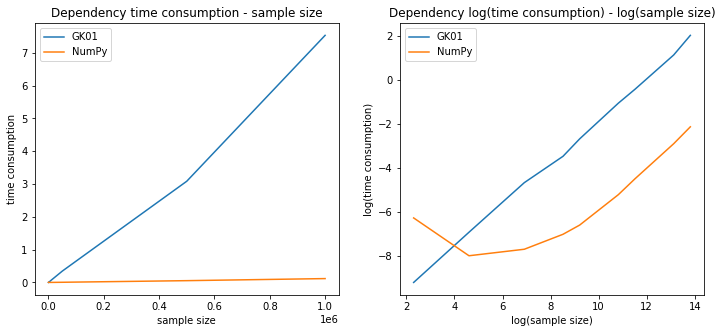

In [30]:
# Show observations on the dependence of the algorithms' time consumption on the sample size
interpret_data(sample_sizes, gk01_time_measure, np_time_measure, 'time consumption')

The size of the object of GK01 algorithm class is 48 bytes
The size of the object of NumPy algorithm class is 48 bytes

   Sample size  GK01    NumPy
0           10   184      192
1          100   328     1000
2         1000   328     9104
3         5000   296    45104
4        10000   304    90104
5        50000   304   450104
6       100000   296   900104
7       500000   296  4500104
8      1000000   296  9000104



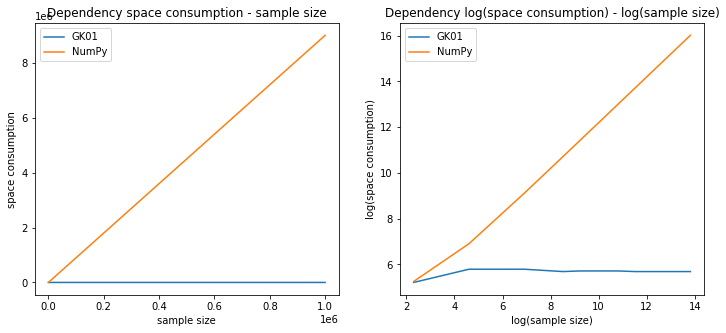

In [31]:
# Note that the amount of memory occupied by objects of classes in which the solution is implemented is the same
# Therefore, space consumption of their data storage was measured
print('The size of the object of GK01 algorithm class is', getsizeof(gk), 'bytes')
print('The size of the object of NumPy algorithm class is', getsizeof(npalg), 'bytes\n')

# Show observations on the dependence of the algorithms' space consumption on the sample size
interpret_data(sample_sizes, gk01_space_measure, np_space_measure, 'space consumption')

## Test

Here you need to show that your algorithm is working properly.
1. Take `normal` distribution. Show, that with increase in sample size, quantiles calculated with your algorithms are become very close to the `inverse cdf` of the distribution. 

2. Perform the same experiment with any other continuous distribution (exponential, logistic, etc.)

The results of the performed analysis showed that the quantile tends to the  inverse cdf of the distribution with increasing sample size. Note that the tendency was influenced by the epsilon approximate of the quantile.
Conducting this experiment on uniform, logistic and exponential distributions also showed that quantile becomes close to the inverse cdf of the distribution with increase in sample size. Based on obtained results, one can conclude that the algorithm works correctly.

Experiment for normal distribution
   Sample size  GK01 quantile  Inverse cdf
0           10       0.796927     1.281552
1          100       1.200481     1.281552
2         1000       1.300741     1.281552
3         5000       1.326728     1.281552
4        10000       1.267038     1.281552
5        50000       1.327829     1.281552
6       100000       1.304456     1.281552
7       500000       1.307314     1.281552
8      1000000       1.300621     1.281552


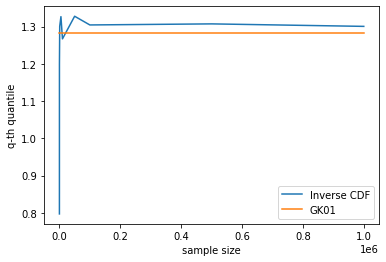

In [35]:
from scipy.stats import norm, uniform, logistic, expon

def experiment(distribution, inverse_cdf, q):
    """
    Conduct the measures of q-th quantile on samples of given distribution with the different sizes
    And compare it to the inverse cdf of this distribution

    :param distribution: a numpy.random function that generates a distribution, e.g. np.random.normal
    :param inverse_cdf: a scipy.stats function that calculates an inverse cdf of the previous distribution, e.g. scipy.stats.norm.ppf
    :param q: q-th quantile for which to conduct an analysis
    """
    gk01_measure = []
    np_measure = []
    sample_sizes = np.array([10, 100, 1000, 5000, 10000, 50000, 100000, 500000, 1000000])

    for n in sample_sizes:
      # Create a sample from the given distribution
        data = distribution(size=n).tolist()

        # Compute q-quantile for the given data
        gk = GK01QuantileAlgorithm(0.01)
        gk.add_multiple_items(data)
        gk01_measure.append(gk.compute_quantile(q))
    
    # Create a line y=inverse_cdf(q)
    inv = [inverse_cdf(q)] * len(sample_sizes)

    # Print the table of the received data
    df = pd.DataFrame({'Sample size': sample_sizes, 'GK01 quantile': gk01_measure, 'Inverse cdf': inv})
    print(df)

    # Plot the dependancy of the computed quantile on the sample size
    plt.plot(sample_sizes, gk01_measure)
    plt.plot(sample_sizes, inv)

    plt.legend(['Inverse CDF', 'GK01', 'NumPy'], loc="best")
    plt.ylabel('q-th quantile')
    plt.xlabel('sample size')
    plt.show()


print("Experiment for normal distribution")
q = 0.9
experiment(np.random.normal, norm.ppf, q)


Experiment for uniform distribution
   Sample size  GK01 quantile  Inverse cdf
0           10       0.905413          0.9
1          100       0.925116          0.9
2         1000       0.914806          0.9
3         5000       0.903424          0.9
4        10000       0.892900          0.9
5        50000       0.898851          0.9
6       100000       0.908185          0.9
7       500000       0.901364          0.9
8      1000000       0.901820          0.9


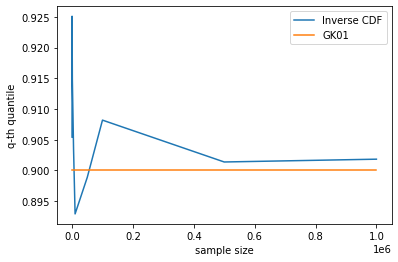


Experiment for logistic distribution
   Sample size  GK01 quantile  Inverse cdf
0           10       1.619653     2.197225
1          100       2.357999     2.197225
2         1000       2.238047     2.197225
3         5000       2.214384     2.197225
4        10000       2.296148     2.197225
5        50000       2.234547     2.197225
6       100000       2.241548     2.197225
7       500000       2.212600     2.197225
8      1000000       2.243928     2.197225


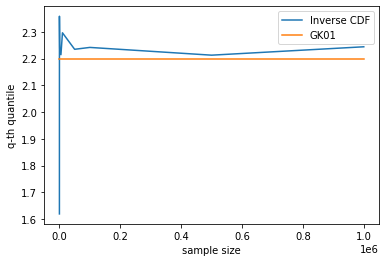


Experiment for exponential distribution
   Sample size  GK01 quantile  Inverse cdf
0           10       1.692263     2.302585
1          100       2.502691     2.302585
2         1000       2.242187     2.302585
3         5000       2.287960     2.302585
4        10000       2.365400     2.302585
5        50000       2.327268     2.302585
6       100000       2.370702     2.302585
7       500000       2.321724     2.302585
8      1000000       2.256214     2.302585


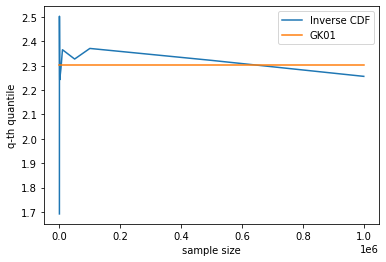

In [33]:
# Repeat the experiment for uniform, logistic and exponential distributions
print("Experiment for uniform distribution")
experiment(np.random.uniform, uniform.ppf, q)

print("\nExperiment for logistic distribution")
experiment(np.random.logistic, logistic.ppf, q)

print("\nExperiment for exponential distribution")
experiment(np.random.exponential, expon.ppf, q)

Perform an experiment that shows the main purpose of the algorithm. 

For example, some algorithms are created especially for time series data, so you should show that your algorithm is working in time series environment properly.

GK01 algorithm is Deterministic and Streaming. Determenistic means that several executions on the same dataset with the same query will give the same result. Streaming algorithms can compute a quantile at any moment after the first datapoint is received, while data elements arrive to it one-by-one. 

To show this properties, let's create a random sample and run an algorithm several times on it. During execution let's ask an algorithm to calculate some quantile. As GK01 is streaming, it will give the answers on each request, and as it is determenistic, this answers will be the same. 

In [34]:
# Create a random sample with a nornal distribution
data = np.random.normal(100,30,15000).tolist()

# Runs will store the results of computing quantiles on different runs of GK01
runs ={}
quantiles = [q/10 for q in range(1,10)]

# Run algorithm several times
for n in range(5):
    gk = GK01QuantileAlgorithm(0.01)
    runs[n] = []
    for i in range(15000):
        # Add items like in a stream: one-by-one
        gk.add_item(data[i])
        # Compute quantile at some random point of time
        if (i+1)%1000==0:
            runs[n].append(gk.compute_quantile(quantiles[i % len(quantiles)]))

# Show the results of computing quantiles on different runs of GK01
df = pd.DataFrame(runs)
df['Equal answers'] = df.eq(df.iloc[:, 0], axis=0).all(1)
print(df)

print("\nResults of the experiment")
# Check if data contains a null value
print("Streaming:", df.isnull().sum().sum()==0)

# Check whether all answers to each request are equal
print("Determenistic:", (df['Equal answers'] == True).sum()==len(df.index))

             0           1           2           3           4  Equal answers
0    62.047767   62.047767   62.047767   62.047767   62.047767           True
1    74.467200   74.467200   74.467200   74.467200   74.467200           True
2    83.420720   83.420720   83.420720   83.420720   83.420720           True
3    91.616757   91.616757   91.616757   91.616757   91.616757           True
4    99.404728   99.404728   99.404728   99.404728   99.404728           True
5   106.918206  106.918206  106.918206  106.918206  106.918206           True
6   116.692734  116.692734  116.692734  116.692734  116.692734           True
7   124.606391  124.606391  124.606391  124.606391  124.606391           True
8   138.760427  138.760427  138.760427  138.760427  138.760427           True
9    63.246862   63.246862   63.246862   63.246862   63.246862           True
10   74.467200   74.467200   74.467200   74.467200   74.467200           True
11   84.493361   84.493361   84.493361   84.493361   84.493361  